In [7]:
import datetime
import json
import vk
import operator
import matplotlib.pyplot as plt
import numpy as np
import os
import gensim
import gensim.corpora as corpora
import pyLDAvis
import nltk
from nltk.corpus import stopwords
import pyLDAvis.gensim
import pymorphy2
from wordcloud import WordCloud
import numpy as np
import operator
from PIL import Image

In [7]:
token = ''
vk_api = vk.API(vk.Session(access_token=token))
print('Success connect!')

Success connect!


In [8]:
public_name = ['hsemem', 'msuofmems']

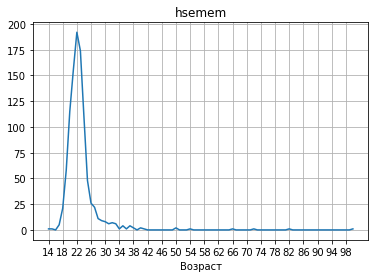

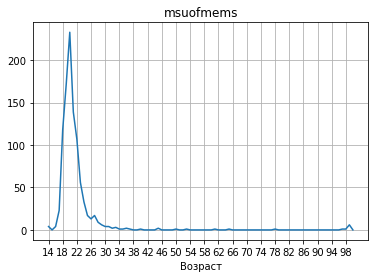

In [5]:
# Собираем id подписоты


"""
for k in public_name:
    first = vk_api.groups.getMembers(group_id=k, v=5.92)
    data = first["items"]
    for i in range(1, first["count"] // 1000 + 1):
        print(i)
        data += vk_api.groups.getMembers(group_id=k, v=5.92, offset=i * 1000)["items"]
    with open(f'data/{k}.txt', "w") as file:
        for item in data:
            file.write(f'{item}\n')
"""

# Собираю все страницы пользователей вк
# Сохраняю в файл чтобы не потерять


"""
    for name in public_name:
        peop = 0
        with open(f'data/{name}.txt', 'r') as file:
            data = file.readlines()
        massive = [int(i.split('\n')[0]) for i in data]
        res = {}
        for i in range(0, len(massive), 1):
            print('People', peop)
            try:
                user = vk_api.users.get(user_ids=massive[i], v=5.92, fields=['sex', 'bdate',
                                                                             'city', 'country', 'home_town'])[0]
                print(user)
                if len(user['bdate'].split('.')) == 3:
                    res[massive[i]] = {'user': user,
                                       'wall': vk_api.wall.get(owner_id=user['id'], v=5.92),
                                       'sub': vk_api.users.getSubscriptions(user_id=massive[i], v=5.92)}
                    peop += 1
                    if peop % 100 == 0:
                        with open(f'data/{name}.json', 'w') as file:
                            json.dump(res, file)
            except Exception as e:
                print(e)
                pass
"""


# Узнаю возраст подписчиков
def years_old():
    # Рисую графики, зависимость количества подписчкиов от их возраста
    def plot():
        arr = []
        for fn in public_name:
            with open(f'data/{fn}/{fn}-ages.json') as file:
                data = json.load(file)
            arr1 = []
            for i in data['age'].keys():
                arr1.append(data['age'][i])
            arr.append(arr1)
        for i in range(len(arr)):
            x = [t for t in range(14, 14 + len(arr[i]))]
            plt.plot(x, arr[i])
            plt.xlabel('Возраст')
            plt.title(f'{public_name[i]}')
            plt.grid(which='major')
            plt.xticks([k for k in range(14, 101, 4)])
            plt.show()

    # Прогоняю два паблика.
    # Ищу средний возраст и отдельно для каждого подписчика (от 14 до 100 лет) (14 - мин. возраст)
    for f in public_name:
        mean = 0
        with open(f'data/{f}.json') as file:
            born = json.load(file)
        ages = {}
        for i in range(14, 101):
            ages[i] = 0
        for i in born.keys():
            # Не учитываю день и месяц, потому что скоро Новый Год :)
            difference = datetime.datetime.today().year - \
                         datetime.datetime.strptime(born[i]['user']['bdate'], "%d.%m.%Y").year
            mean += difference
            if 14 <= difference < 101:
                ages[difference] += 1
        mean = int(mean / len(born))
        with open(f'data/{f}/{f}-ages.json', 'w') as file:
            json.dump({'mean': mean, 'age': ages}, file)
    # Отрисовываю графики
    plot()



# Исследуем возраст
years_old()


# В данной части кода мы собрали id пользователей двух групп. После пропарсили их страницы, собрали возраст, город,
# подписки на группы и прочие данные. Функция years_old() отображает количество подписчиков опредеделенного возраста.


# Что видим на графиках? Да ничего толкового... Только то, что бОльшая часть аудитории данных пабликов
# в возрасте от ~18 до ~26 лет.

In [11]:
def popular_groups():
    # Собираю группы, на которые подписаны пользователи
    def parse_groups():
        for file_name in public_name:
            k = 0
            with open(f'data/{file_name}.json', 'r') as f:
                data = json.load(f)
                user = {}
                for i in data.keys():
                    # print(k)
                    id_proups = {f"{data[i]['sub']['groups']['items'][k]}": data[i]['sub']['groups']['items'][k]
                                 for k in range(len(data[i]['sub']['groups']['items']))}
                    user[i] = id_proups
                    k += 1
            with open(f'data/{file_name}/{file_name}-group-list.json', 'w') as file:
                json.dump(user, file)

    # Рисуем картинку с популярными группами
    def popular_gr():
        for file_name in public_name:
            with open(f'data/{file_name}/{file_name}-group-list.json', 'r') as file:
                data = json.load(file)
            gr = {}
            for i in data.keys():
                for k in data[i]:
                    if k in gr.keys():
                        gr[k] += 1
                    else:
                        gr[k] = 1
            a = sorted(gr.items(), key=operator.itemgetter(1), reverse=True)
            aaa = []
            for i in range(len(a)):
                if i < 10:
                    aaa.append(a[i][1])
                else:
                    break
            names = []
            for i in range(len(a)):
                if i < 10:
                    names.append(vk_api.groups.getById(group_ids=int(a[i][0]), v=5.92)[0]['name'])
                else:
                    break
            fig, ax = plt.subplots()
            wedges, texts, autotexts = ax.pie(aaa, autopct='%1.1f%%')
            ax.legend(wedges, names,
                      title="Группы",
                      loc='upper left',
                      bbox_to_anchor=(1, 1.15),
                      fontsize='small',
                      framealpha=0.3)
            plt.title(f'{file_name}')
            plt.show()

    parse_groups()
    popular_gr()


popular_groups()


# О боже! Что мы видим! На 4 месте по популярности у МГУшников - группа ХАЙЕР СКУЛ ОФ МЕМС. Но что интересно,
# группа с мемасами из МГУ даже не входит в топ 10 у студентов ХСЕ. Отсюда следует вывод, что админы и студенты МГУ
# не умеют делать смешные мемы, а значит у них плохое чувство юмора. Как известно, чувство юмора у человека и
# способность осознания шутки напрямую связаны с уровнем интеллекта человека. Следовательно, очевидно,
# что у студентов ХСЕ более высокий IQ по сравнению со студентами мгу (специально строчными буквами).

# А если вдруг начнётся геноцид студентов мгу, то все мы знаем, в какой группе их искать!

NameError: name 'vk_api' is not defined

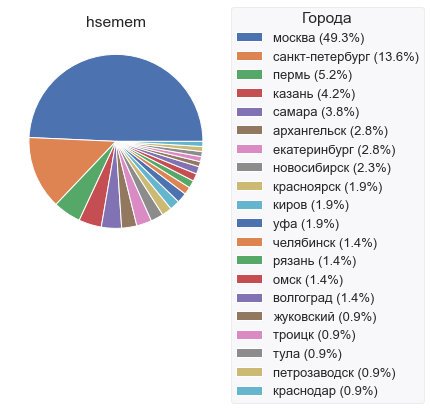

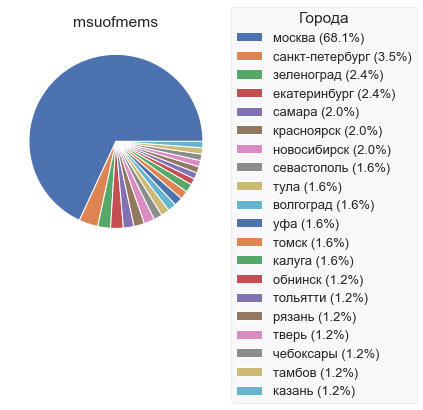

In [10]:
def home_town():
    for name in public_name:
        with open(f'data/{name}.json', 'r') as file:
            data = json.load(file)
        city = {}
        for i in data.keys():
            try:
                town = data[i]['user']['home_town'].lower()
                if ' ' in town:
                    town = town.splt(' ')[1]
                if town == 'moscow':
                    town = 'москва'
                if town in city.keys() and town != '':
                        city[town] += 1
                elif town != '':
                    city[town] = 1
            except:
                pass
        a = sorted(city.items(), key=operator.itemgetter(1), reverse=True)
        aaa = []
        for i in range(len(a)):
            if i < 20:
                aaa.append(a[i][1])
            else:
                break
        names = []
        for i in range(len(a)):
            if i < 20:
                names.append(a[i][0])
            else:
                break
        total = sum(aaa)
        labels = [f"{n} ({v / total:.1%})" for n, v in zip(names, aaa)]
        fig, ax = plt.subplots()
        ax.pie(aaa)
        ax.legend(labels,
                  title="Города",
                  loc='upper left',
                  bbox_to_anchor=(1, 1.15),
                  fontsize='small',
                  framealpha=0.3)
        plt.title(f'{name}')
        plt.show()


home_town()


# Интересно, из каких городов приехали студенты?
# Как видим, бОльшая часть студентов (подписчиков) двух университетов из Москвы.
# Из регионов студентов не так много.
# Стоит обратить внимание на диаграмму ХСЕ: в ТОП-4 входят такие города как Питер, Пермь и Казань. 

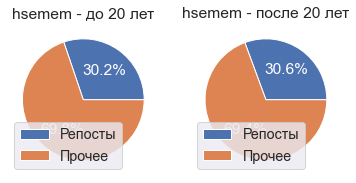

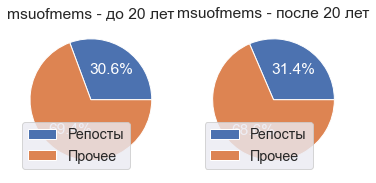

In [9]:
for name in public_name:
    with open(f'data/{name}.json', 'r') as file:
        data = json.load(file)
    repost_old = 0
    repost_young = 0
    text_old = 0
    text_young = 0
    for i in data.keys():
        difference = datetime.datetime.today().year - \
                     datetime.datetime.strptime(data[i]['user']['bdate'], "%d.%m.%Y").year
        # print(difference)
        if difference > 20:
            for k in data[i]['wall']['items']:
                text_old += 1
                try:
                    if k['copy_history'][0]['text'] is not None:
                        repost_old += 1
                except:
                    pass
        else:
            for k in data[i]['wall']['items']:
                text_young += 1
                try:
                    if k['copy_history'][0]['text'] is not None:
                        repost_young += 1
                except:
                    pass
    fig, ax = plt.subplots(1, 2)
    ax[0].set_title(f'{name} - до 20 лет')
    ax[0].pie([repost_young, text_young], autopct='%1.1f%%', textprops=dict(color="w"))
    ax[0].legend(['Репосты',
                  'Прочее'])
    ax[1].set_title(f'{name} - после 20 лет')
    ax[1].pie([repost_old, text_old], autopct='%1.1f%%', textprops=dict(color="w"))
    ax[1].legend(['Репосты',
                  'Прочее'])
    plt.show()


# Интересно, как меняется количество репостов у студентов до 20 лет и после 20 лет?
# Как видим, процентная составляющая репостов от обычных записей почти никак не изменяется.
# Поведение студентов не сильно меняется ступстя несколько лет учебы в ХСЕ, и они по-прежнему
# продолжают репостить мемасики и участвовать в розыгрышах.

In [28]:
def to_numpy():
    for file_name in public_name:
        repost = []
        with open(f'data/{file_name}.json', 'r') as f:
            d = json.load(f)
        for i in d.keys():
            for k in d[i]['wall']['items']:
                try:
                    repost.append(k['copy_history'][0]['text'])
                except:
                    pass
        np.save(f'data/{file_name}/{file_name}-repost', np.asarray([i for i in repost if i != '']))
        print('Success save')
    tmp = 0
    for i in public_name:
        data = np.load(f'data/{i}/{i}-repost.npy')
        if tmp == 0:
            tmp = data
        else:
            tmp = np.concatenate((tmp, data))
    np.save('repost', tmp)
    print('Success')


# Конвертирую словарь в одномерный массив, где каждый элемент которого - 1 репост.
to_numpy()

Success save
Success save


e:\python\3.6\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Success


Стоит обратить внимание, что пользователи публикают на своих стенах не так много статей, в отличие от репостов. Если посмотреть на статьи, то можно невооруженным взглядом заметить, что ничего общего между ними нет. У всех разные интересы и увлечения. Отсюда только можно сказать, что люди, подписанные на данные сообщества, - разносторонние личности.
Также стоит обратить внимание, что данных очень очень мало. Их нет смысла пропускать через LDA модель.

Что же касается репостов, то тут всё гораздо интереснее. Можно посмотреть, какие слова чаще всего стречаются в этих записях.
Для этого нужно создать LDA модель.

In [12]:
# Собираем модель!
bad_w = 'твой com наш свой каждый http https vk id ваш её который wall'
part_of_speach = ['INTJ', 'PRCL', 'NPRO', 'CONJ', 'PREP', 'COMP', 'ADVB']


top_w=10


text = np.load('repost.npy')


# Скачиваем стоп-слова
# nltk.download('stopwords')
stopwords_ru = stopwords.words('russian')
stopwords_en = stopwords.words('english')

# Токенизируем
print('Tok')
text = [gensim.utils.simple_preprocess(i) for i in text]

# Количество слов в репосте
text = [x for x in text if len(x) > 20]

# Удаляет плохие словечки
morph = pymorphy2.MorphAnalyzer()

# Начальная форма
print('Clean')
text = [[morph.parse(word)[0].normal_form for word in i] for i in text]

# Удаляем части речи
text = [[word for word in words if morph.parse(word)[0].tag.POS not in part_of_speach] for words in text]

# Удаляю слова
print('Clean2')
text = [[word for word in x if word not in stopwords_ru] for x in text]
text = [[word for word in x if word not in stopwords_en] for x in text]
text = [[word for word in x if word not in bad_w.split(' ')] for x in text]

# Создаем и сразу же фильтруем словарь
dict = corpora.Dictionary(text)
dict.filter_extremes(no_below=10, no_above=0.5)
corpus = [dict.doc2bow(i) for i in text]

# Создаю LDA модель для анализа
print('LDA')
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dict, num_topics=top_w)

# Если нет директории, то создадим
print('Save')
if not os.path.isdir('LDA'):
    os.mkdir('LDA')
# Созраним модель, чтобы использовать в будущем
lda_model.save('LDA/LDA_model_repost')

# Визуализируем
pyLDAvis.enable_notebook()  # Для юпитер ноутбука
visualisation = pyLDAvis.gensim.prepare(lda_model, corpus, dict)
pyLDAvis.save_html(visualisation, f'LDA/Visual-repost.html')

# Берем самые популярные топики по 50 слов в каждом
topics = lda_model.show_topics(num_topics=top_w, num_words=50, formatted=False)
np.save('all_words_repost', topics)
print('Success')

Tok
Clean
Clean2
LDA
Save
Success


e:\python\3.6\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


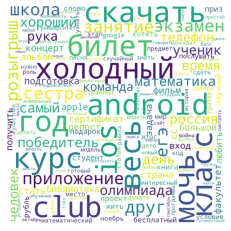

In [14]:
# text = topics
text = np.load('all_words_repost.npy', allow_pickle=True)


# Соберем все сова по вероятности в одну строку
popular = {}
for category in text:
    words = category[1]
    for i in range(len(words)):
        if i > 50:
            break
        popular.setdefault(words[i][0], words[i][1])
sorted_words = sorted(popular.items(), key=operator.itemgetter(1), reverse=True)
text = ''
for item in sorted_words:
    text += ' ' + item[0]


wc = WordCloud(max_font_size=200, max_words=150, width=1500, height=1500, background_color="white")
wc.generate(text)
a = wc.to_array()
"""a = Image.fromarray(a)
a.show()"""
plt.imshow(a)
plt.axis("off")
plt.show()

# Вывод:

На последней картинке показаны самые популярные слова среди студентов двух вузов.

Присутствует много ключевых слов, которые чаще всего студенты используют в своём лексиконе. Например: факультет, проект, студент, школа (высшая школа экономики), библиотека, научный и прочее.

Помимо этого присутствуют слова по типу "репост" и "розыгрыш". Следовательно, также студенты увлекаются розыгрышами и ХАЛЯВОЙ! Например, билеты на концерт (слово билет изображено на картинке).
В общем говоря, картинка получилась очень содержательная.

In [3]:
import seaborn as sns
from gensim.models import LdaModel
import pandas as pd
import matplotlib.pyplot as plt

(10, 7732)


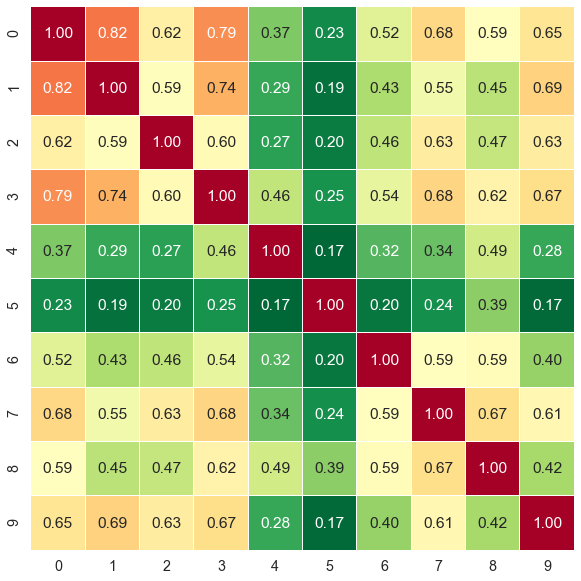

In [5]:
model = LdaModel.load('LDA/LDA_model_repost')
Phi = model.state.get_lambda()
print(Phi.shape)
S = pd.DataFrame(Phi.T).corr()

sns.set(font_scale=1.3)
plt.subplots(figsize=(10, 10))
sns.heatmap(S, square=True,
            annot=True, fmt=".2f", linewidths=0.1, cmap="RdYlGn_r",
            cbar=False)

На картинке выше изображена тепловая карта, т.е. схожесть тем между собой. Как видим, схожих тем не так много, что радует. Следовательно, подтверждается теория, что люди разносторонние.